# Imports

In [ ]:
# Importar librerias
import os
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
from librosa.util import normalize, fix_length
from scipy.signal import butter
from scipy.signal import filtfilt
from keras.utils import to_categorical
from PIL import Image
import pickle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.layers as LK
import tensorflow.keras.models as MK
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
!pip install noisereduce
import noisereduce as nr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Frecuencia de muestreo
fs = 44100
# Definir el umbral de silencio en dB
top_db = 20

#Definir los parámetros para el espectrograma de mel
n_fft_parameter = int(0.025 * fs) # 25 ms en muestras
hop_length_parameter = int(n_fft_parameter/2) # 10 ms en muestras
n_mels_parameter = 40

# Lectura de archivos
# NO EJECUTAR A LA LIGERA
### WARNING
### WARNING 2
###NO EJECUTES POR FAVOR

In [ ]:
carpetasAudios = os.listdir('/content/drive/MyDrive/Audios Señales')
carpetasAudios.sort()

for label, audioBruto in enumerate(carpetasAudios):
  for fileName in glob.glob(os.path.join('/content/drive/MyDrive/Audios Señales', audioBruto, '*.wav')):
    try:
      signal, sr = librosa.load(fileName, mono=True, sr=fs)
      trimmed_signal = librosa.effects.trim(signal, top_db= 20)
      reduced_noise_signal = nr.reduce_noise(trimmed_signal[0], fs)
      normalized_signal = librosa.util.normalize(reduced_noise_signal)

      plt.specgram(x=normalized_signal, Fs=fs, Fc=0, NFFT=n_fft_parameter, cmap=plt.cm.jet, scale='dB')
      plt.axis('off')
      plt.savefig(f'{fileName[:-3].replace(".","")}.jpg')
      plt.clf
      plt.cla()
      plt.close()

    except Exception as e:
      print(f'Error: {e}')
      continue
      print('TODO AZAROSO')

KeyboardInterrupt: ignored

# Lectura de Espectogramas

In [ ]:
carpetasEspectogramas = os.listdir('/content/drive/MyDrive/Espectogramas Señales')
carpetasEspectogramas.sort()

dataset = []

for label_spectogram, espectogramaBruto in enumerate(carpetasEspectogramas):
  for fileNameSpecgram in glob.glob(os.path.join('/content/drive/MyDrive/Espectogramas Señales', espectogramaBruto, '*.jpg')):
    try:

      img = Image.open(fileNameSpecgram)
      box = (80, 58, 576, 427)
      img_crop = img.crop(box)
      img_array = np.asarray(img_crop)
      dataset.append([img_array, label_spectogram])

    except Exception as e:
      print(f'Error: {e}')
      continue
      print('TODO AZAROSO')

spectogram= pd.DataFrame(dataset, columns=['ESPECTOGRAMAS', 'ETIQUETA'])

In [ ]:
spectogram.head(-1)

,ESPECTOGRAMAS,ETIQUETA
0,"[[[62, 231, 228], [62, 231, 228], [62, 231, 22...",0
1,"[[[8, 92, 208], [8, 92, 208], [8, 92, 208], [8...",0
2,"[[[33, 134, 216], [33, 134, 216], [33, 134, 21...",0
3,"[[[118, 238, 164], [118, 238, 164], [118, 238,...",0
4,"[[[39, 223, 233], [39, 223, 233], [40, 222, 23...",0
...,...,...
659,"[[[117, 242, 164], [116, 243, 172], [108, 241,...",4
660,"[[[87, 248, 180], [88, 247, 180], [90, 247, 18...",4
661,"[[[96, 238, 180], [96, 238, 180], [96, 238, 18...",4
662,"[[[44, 225, 236], [44, 225, 236], [44, 224, 23...",4


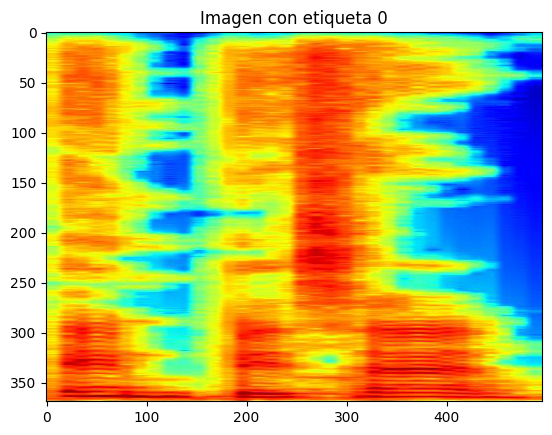

In [ ]:
imagen = spectogram.loc[5, 'ESPECTOGRAMAS']
etiqueta = spectogram.loc[5, 'ETIQUETA']
plt.imshow(imagen)
plt.title('Imagen con etiqueta {}'.format(etiqueta))
plt.show()

In [ ]:
x = np.array(spectogram.ESPECTOGRAMAS.tolist())
y =np.array(spectogram.ETIQUETA.tolist())
y = y.reshape((y.shape[0],-1))
print(x.shape)
print(y.shape)

(665, 369, 496, 3)
(665, 1)


In [ ]:
x[0][200][339][2]

0

In [ ]:
y[664][0]

4

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10, stratify=y)
print(x_train.shape, y_train.shape, y_test.shape )

(532, 369, 496, 3) (532, 1) (133, 1)


In [ ]:
y_train[0]

array([0])

In [ ]:
#RESHAPE DEL NONE

x_train = x_train.reshape((x_train.shape[0], 369, 496, 3))
x_test = x_test.reshape((x_test.shape[0], 369, 496, 3))
print("Imagenes de entrenamiento Tamaño:%s, Tamaño de las etiquetas%s" %(x_train.shape, y_train.shape))
print("Imagenes de prueba tamaño:{0}, Tamaño de las etiquetas:{1}".format(x_test.shape, y_test.shape))

Imagenes de entrenamiento Tamaño:(532, 369, 496, 3), Tamaño de las etiquetas(532, 1)
Imagenes de prueba tamaño:(133, 369, 496, 3), Tamaño de las etiquetas:(133, 1)


# RED NEURONAL CONVOLUCIONAL BASADO EN VGG-19

In [ ]:
#CONVOLUCIÓN

entrada = LK.Input(shape=(369, 496, 3))
conv1 = LK.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(entrada)
conv2 = LK.Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(conv1)
pool1 = LK.MaxPool2D(pool_size=(2,2), strides=(2,2))(conv2)

conv3 = LK.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(pool1)
conv4 = LK.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(conv3)
pool2 = LK.MaxPool2D(pool_size=(2,2), strides=(2,2))(conv4)

conv5 = LK.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(pool2)
conv6 = LK.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(conv5)
pool3 = LK.MaxPool2D(pool_size=(2,2), strides=(2,2))(conv6)

conv7 = LK.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(pool3)
conv8 = LK.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(conv7)
pool4 = LK.MaxPool2D(pool_size=(2,2), strides=(2,2))(conv8)

conv8 = LK.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool4)
conv9 = LK.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(conv8)
pool5 = LK.MaxPool2D(pool_size=(2,2), strides=(2,2))(conv9)

#FLATTEN

flat = LK.Flatten()(pool5)

#RED NEURONAL

fc1 = LK.Dense(units=1024, activation='relu', kernel_regularizer= tf.keras.regularizers.L2(0.01))(flat)
drop = LK.Dropout(0.25)(fc1)
fc2 = LK.Dense(units=1024, activation='relu', kernel_regularizer= tf.keras.regularizers.L2(0.01))(drop)
drop1 = LK.Dropout(0.3)(fc2)
fc3 = LK.Dense(units=1024, activation='relu', kernel_regularizer= tf.keras.regularizers.L2(0.01))(drop1)
drop2 = LK.Dropout(0.25)(fc3)
salida = LK.Dense(units=5, activation='softmax')(drop2)

In [ ]:
#SUMMARY

gonodactylus_simithii = MK.Model(entrada, salida)
gonodactylus_simithii.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 369, 496, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 369, 496, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 369, 496, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 184, 248, 8)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 184, 248, 16)      1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 184, 248, 16)      2320      
                                                             

In [ ]:
#SE DEBE USAR SI NO SE QUIERE USAR TRANSFER LEARNING Y REINICIAR LOS PESOS DEL MODELO

tf.keras.backend.clear_session

<function keras.backend.clear_session()>

In [ ]:
#COMPILE MODEL

optimo='adam'
gonodactylus_simithii.compile(optimizer=optimo, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import gc
gc.collect()

52941

In [ ]:
#HISTORY
#Batch_size=128   Cada 128 imágenes cambia los pesos y propaga el error

# Definir ruta y nombre del archivo para guardar el modelo
filepath = "mejor_modelo_entrenado.h5"

# Definir el callback para guardar los pesos del modelo con la mejor precisión en validación y los pesos cada 2 épocas
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max', period=2)

# Entrenar el modelo con el callback
historia = gonodactylus_simithii.fit(x_train, y_train, epochs=150, batch_size=128, validation_data=(x_test, y_test), verbose=1, callbacks=[checkpoint])

# Evaluar el modelo
loss, acc = gonodactylus_simithii.evaluate(x_test, y_test, verbose=1)
print("El loss es de: {0}, y el accuracy es de: {1}".format(loss, acc))


Epoch 1/150
5/5 [==============================] - 3s 560ms/step - loss: 0.2588 - accuracy: 0.9944 - val_loss: 0.6861 - val_accuracy: 0.8947
Epoch 2/150
5/5 [==============================] - ETA: 0s - loss: 0.2412 - accuracy: 0.9981
Epoch 2: val_accuracy improved from -inf to 0.88722, saving model to mejor_modelo_entrenado.h5
5/5 [==============================] - 3s 579ms/step - loss: 0.2412 - accuracy: 0.9981 - val_loss: 0.7709 - val_accuracy: 0.8872
Epoch 3/150
5/5 [==============================] - 2s 481ms/step - loss: 0.2242 - accuracy: 1.0000 - val_loss: 0.9274 - val_accuracy: 0.8647
Epoch 4/150
5/5 [==============================] - ETA: 0s - loss: 0.2337 - accuracy: 0.9962
Epoch 4: val_accuracy improved from 0.88722 to 0.90226, saving model to mejor_modelo_entrenado.h5
5/5 [==============================] - 3s 558ms/step - loss: 0.2337 - accuracy: 0.9962 - val_loss: 0.6754 - val_accuracy: 0.9023
Epoch 5/150
5/5 [==============================] - 3s 525ms/step - loss: 0.2077 -

## Métricas

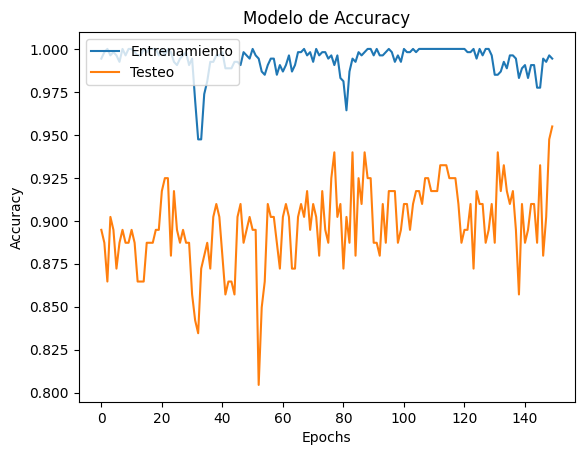

In [ ]:
plt.plot(historia.history['accuracy'])
plt.plot(historia.history['val_accuracy'])
plt.title("Modelo de Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Entrenamiento', 'Testeo'], loc='upper left')
plt.show()

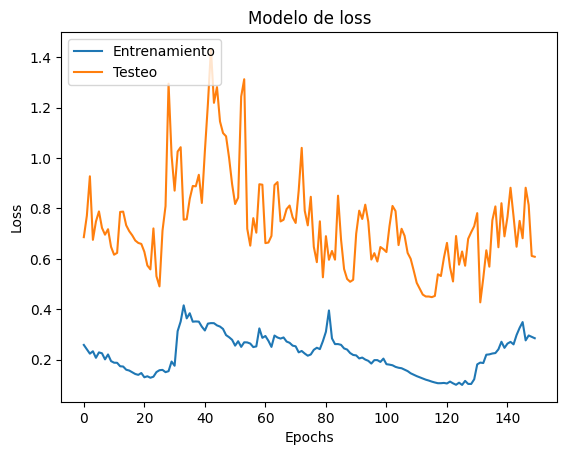

In [ ]:
plt.plot(historia.history['loss'])
plt.plot(historia.history['val_loss'])
plt.title("Modelo de loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Entrenamiento', 'Testeo'], loc='upper left')
plt.show()

5/5 [==============================] - 0s 43ms/step


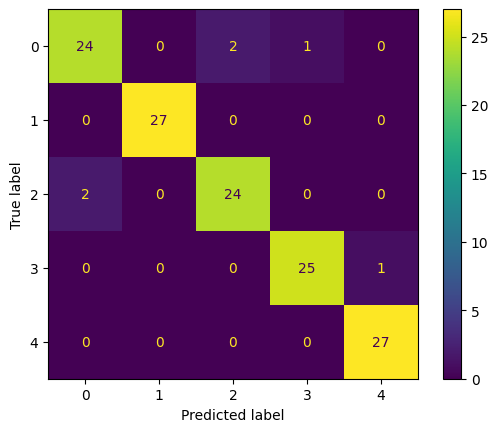

In [ ]:
y_pred = gonodactylus_simithii.predict(x_test)
result = confusion_matrix(y_test, y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(result)
disp.plot()
plt.show()

In [ ]:
print(y_test)

[2 4 2 1 3 4 3 4 1 4 3 4 2 0 3 2 2 2 3 2 3 4 0 1 3 0 3 4 2 0 4 4 3 2 0 1 3
 0 1 0 4 4 2 1 1 0 4 3 0 3 0 3 3 4 1 1 1 3 2 3 0 3 3 3 2 1 4 4 0 4 2 1 1 1
 0 4 2 0 0 0 3 0 3 2 4 0 1 0 2 4 4 1 1 2 1 2 0 2 4 4 1 0 0 0 1 2 1 4 3 0 4
 4 4 1 0 2 2 1 2 0 3 2 4 1 3 1 2 3 2 3 1 0 1]


In [ ]:
print(y_pred.argmax(axis=1))

[2 4 2 1 3 4 3 4 1 4 3 4 2 0 3 2 2 2 3 2 3 4 0 1 3 0 3 4 2 0 4 4 3 2 0 1 3
 0 1 0 4 4 0 1 1 0 4 3 0 3 3 3 3 4 1 1 1 3 0 3 0 3 3 3 2 1 4 4 0 4 2 1 1 1
 0 4 2 0 0 2 4 0 3 2 4 0 1 2 2 4 4 1 1 2 1 2 0 2 4 4 1 0 0 0 1 2 1 4 3 0 4
 4 4 1 0 2 2 1 2 0 3 2 4 1 3 1 2 3 2 3 1 0 1]


# GUARDAR MODELO

In [ ]:
tf.keras.saving.save_model(
    gonodactylus_simithii, 'Nika_definitivo.h5', overwrite=True, save_format='h5')

In [ ]:
#Cargando el modelo y recreando un nuevo modelo
modelito_nuevo = MK.load_model('Nika.h5')
modelito_nuevo.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 369, 496, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 369, 496, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 369, 496, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 184, 248, 8)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 184, 248, 16)      1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 184, 248, 16)      2320      
                                                             

In [ ]:
# Entrenar el modelo con el callback
historia_nueva = modelito_nuevo.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test), verbose=1)

# Evaluar el modelo
loss_nuevo, acc_nuevo = modelito_nuevo.evaluate(x_test, y_test, verbose=1)
print("El loss es de: {0}, y el accuracy es de: {1}".format(loss_nuevo, acc_nuevo))

# Guardar el historial en un archivo separado
with open('historialPickle.pkl', 'wb') as file:
    pickle.dump(historia_nueva.history, file)

np.save('historialNumpy.npy', historia_nueva.history)

Epoch 1/50
5/5 [==============================] - 29s 1s/step - loss: 0.3719 - accuracy: 0.9774 - val_loss: 0.3266 - val_accuracy: 0.9850
Epoch 2/50
5/5 [==============================] - 2s 438ms/step - loss: 0.3512 - accuracy: 0.9737 - val_loss: 0.3279 - val_accuracy: 0.9850
Epoch 3/50
5/5 [==============================] - 2s 472ms/step - loss: 0.3232 - accuracy: 0.9887 - val_loss: 0.3592 - val_accuracy: 0.9850
Epoch 4/50
5/5 [==============================] - 2s 473ms/step - loss: 0.2873 - accuracy: 0.9925 - val_loss: 0.4250 - val_accuracy: 0.9774
Epoch 5/50
5/5 [==============================] - 2s 480ms/step - loss: 0.2864 - accuracy: 0.9944 - val_loss: 0.4690 - val_accuracy: 0.9549
Epoch 6/50
5/5 [==============================] - 2s 446ms/step - loss: 0.2778 - accuracy: 0.9906 - val_loss: 0.4753 - val_accuracy: 0.9549
Epoch 7/50
5/5 [==============================] - 2s 442ms/step - loss: 0.3157 - accuracy: 0.9906 - val_loss: 0.3757 - val_accuracy: 0.9699
Epoch 8/50
5/5 [======

In [ ]:
#Chequear que el nuevo modelo hace lo mismo que el original
loss_nuevo_evaluado, acc_nuevo_evaluado = modelito_nuevo.evaluate(x_test, y_test, verbose=2)
print('Accuracy del modelo restaurado: {:5.2f}%'.format(100 * acc_nuevo_evaluado) )

5/5 - 0s - loss: 0.3736 - accuracy: 0.9624 - 249ms/epoch - 50ms/step
Accuracy del modelo restaurado: 96.24%


## Métricas

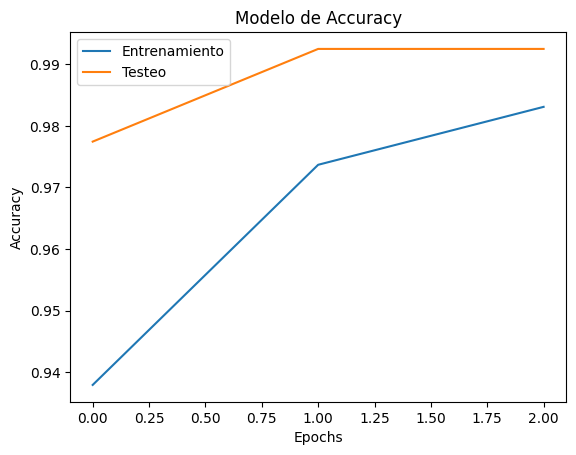

In [ ]:
plt.plot(historia_nueva.history['accuracy'])
plt.plot(historia_nueva.history['val_accuracy'])
plt.title("Modelo de Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Entrenamiento', 'Testeo'], loc='upper left')
plt.show()

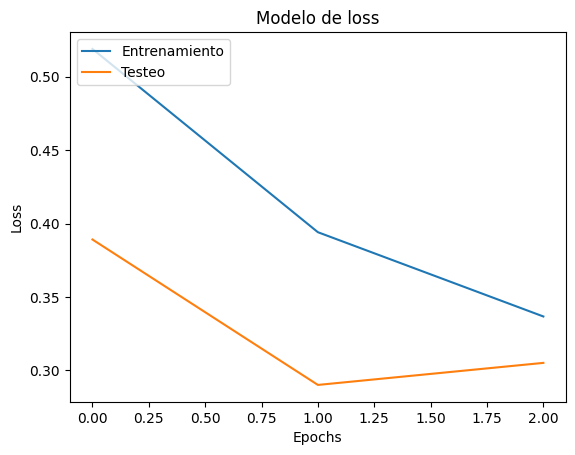

In [ ]:
plt.plot(historia_nueva.history['loss'])
plt.plot(historia_nueva.history['val_loss'])
plt.title("Modelo de loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Entrenamiento', 'Testeo'], loc='upper left')
plt.show()

5/5 [==============================] - 0s 43ms/step


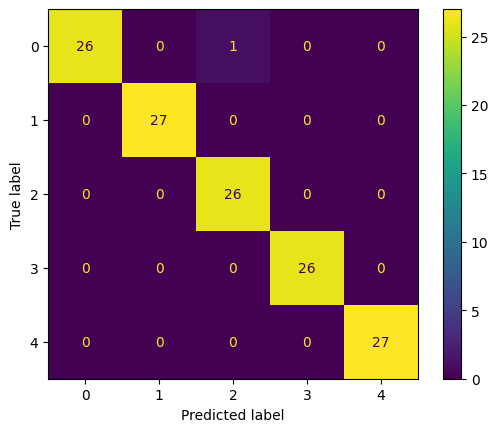

In [ ]:
y_pred = modelito_nuevo.predict(x_test)
result = confusion_matrix(y_test, y_pred.argmax(axis=1))
disp = ConfusionMatrixDisplay(result)
disp.plot()
plt.show()

In [ ]:
tf.keras.saving.save_model(
    modelito_nuevo, 'Nika_Cenit.h5', overwrite=True, save_format='h5')

In [ ]:
print(y_test.ravel())

[2 4 2 1 3 4 3 4 1 4 3 4 2 0 3 2 2 2 3 2 3 4 0 1 3 0 3 4 2 0 4 4 3 2 0 1 3
 0 1 0 4 4 2 1 1 0 4 3 0 3 0 3 3 4 1 1 1 3 2 3 0 3 3 3 2 1 4 4 0 4 2 1 1 1
 0 4 2 0 0 0 3 0 3 2 4 0 1 0 2 4 4 1 1 2 1 2 0 2 4 4 1 0 0 0 1 2 1 4 3 0 4
 4 4 1 0 2 2 1 2 0 3 2 4 1 3 1 2 3 2 3 1 0 1]


In [ ]:
print(y_pred.argmax(axis=1))

[2 4 2 1 3 4 3 4 1 4 3 4 2 0 3 2 2 2 3 2 3 4 0 1 3 0 3 4 2 0 4 4 3 2 0 1 3
 0 1 0 4 4 2 1 1 0 4 3 0 3 0 3 3 4 1 1 1 3 2 3 2 3 3 3 2 1 4 4 0 4 2 1 1 1
 0 4 2 0 0 0 3 0 3 2 4 0 1 0 2 4 4 1 1 2 1 2 0 2 4 4 1 0 0 0 1 2 1 4 3 0 4
 4 4 1 0 2 2 1 2 0 3 2 4 1 3 1 2 3 2 3 1 0 1]


# Prueba Unitaria

## Cargar un audio de testeo y procesarlo

In [ ]:
import io

carpeta_a_escoger = "Leprechaun"
ruta = f"/content/drive/MyDrive/Audios Señales/{carpeta_a_escoger}/{carpeta_a_escoger}_10.wav"

def pruebaAudio(signal):

    signal, sr = librosa.load(ruta, mono=True, sr=fs)
    trimmed_signal = librosa.effects.trim(signal, top_db= 20)
    reduced_noise_signal = nr.reduce_noise(trimmed_signal[0], fs)
    normalized_signal = librosa.util.normalize(reduced_noise_signal)

    fig, ax = plt.subplots()
    spectrum, frequs, t, im = ax.specgram(x=normalized_signal, Fs=fs, Fc=0, NFFT=n_fft_parameter, cmap=plt.cm.jet, scale='dB')
    ax.axis('off')
    buf = io.BytesIO()
    fig.savefig(buf, format='jpg', bbox_inches='tight', pad_inches=0, transparent=True)
    buf.seek(0)
    img = Image.open(buf)
    plt.close()

    box = (80, 58, 576, 427)
    img_crop = img.crop(box)
    img_array = np.asarray(img)

    plt.imshow(img_array, cmap='gray')
    plt.axis('off')
    plt.show()
    return img_array


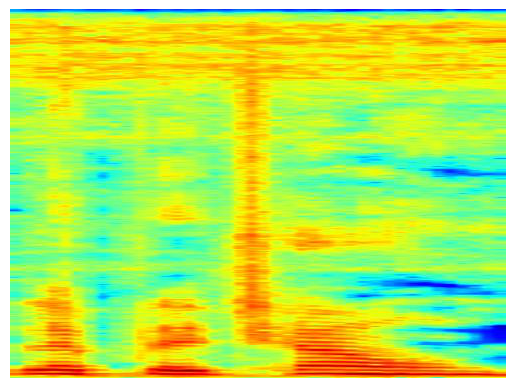

In [ ]:
audioBruto, s = librosa.load(path=ruta, sr= fs, mono=True)
prueba_signals = pruebaAudio(audioBruto)
prueba_signals = prueba_signals.reshape((1, 369, 496, 3))

In [ ]:
prueba_signals.shape

(1, 369, 496, 3)

## Cargamos el modelito_nuevo

In [ ]:
prediccion = modelito_nuevo.predict(prueba_signals).argmax()
print(prediccion)
prediccion_proba = modelito_nuevo.predict(prueba_signals)
print(prediccion_proba)

1/1 [==============================] - 0s 28ms/step
2
1/1 [==============================] - 0s 21ms/step
[[2.4561575e-04 4.2885728e-04 9.9931407e-01 7.6934163e-07 1.0748217e-05]]
